In [6]:
#https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/
#Distance Calculation and Nearest Neighbor Calulation sourced from website above
#https://simplemaps.com/data/world-cities List of World Cities and their population

#Please mount both worldcities.csv and GDT_2000_2019.csv

#WARNING = This section can take up to 10 minutes to run.

from geopy.distance import geodesic
from math import sqrt
import pandas as pd
from itertools import product
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

#This calculates the distance between the Terrorist Event location as well as all 208 Capital cities in the world
#Also returns distance from Equator
def haversine_vectorize(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    miles = 3958 * dist # Multiplying Distance by Miles/Radius of the Earth
    index_location = np.where(miles == miles.min())

    #Getting Distance From Equator
    lon1_2, lat1_2 = map(np.radians, [lon1, lat1])
    newlon_2 = 0
    newlat_2 = 0 - lat1
    haver_formula = np.sin(newlat_2 / 2.0) ** 2 + np.cos(lat1_2) * np.cos(0) * np.sin(newlon_2 / 2.0) ** 2
    dist_2 = 2 * np.arcsin(np.sqrt(haver_formula))
    miles_2 = 3958 * dist_2  # Multiplying Distance by Miles/Radius of the Earth
    try:
        loc = int(index_location[0])
    except:
        loc = 999999
    if len(index_location) == 0 or int(loc) == 999999:
        print("empty")
        print(index_location[0])
        print(lon1)
        print(lat1)
        return 20000, 0,0
    else:
        return np.min(miles),int(loc),miles_2



terrordata = pd.read_csv(
     '/content/GDT_2000_2019.csv')

#remove events where the location is not known
terrordata = terrordata[terrordata['latitude'].notna()]
cities = pd.read_csv('/content/worldcities.csv')
cities = cities[cities["capital"] == "primary"].reset_index()
cities['Key'] = cities.index


#This line takes around 10+ minutes to complete. It is calculating every line against all other 208 Capital Cities. It returns the closest one.
terrordata[['Event_Distance','Key', 'Distance_To_Equator']] = terrordata.apply(lambda row : haversine_vectorize(row['longitude'],row['latitude'],cities['lng'], cities['lat']), axis=1, result_type='expand')
terrordata['Key'] = terrordata['Key'].astype(int)
combined_data = pd.merge(terrordata,cities, on="Key")
#print(combined_data[['latitude','longitude', 'Event_Distance', 'population','city', 'lat','lng','Key']].sort_values(by=['Event_Distance']))

combined_data['Capital_City_Event'] = np.where(combined_data['Event_Distance'] <= 20, True, False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0.15212124929087256
5.0612993209589865


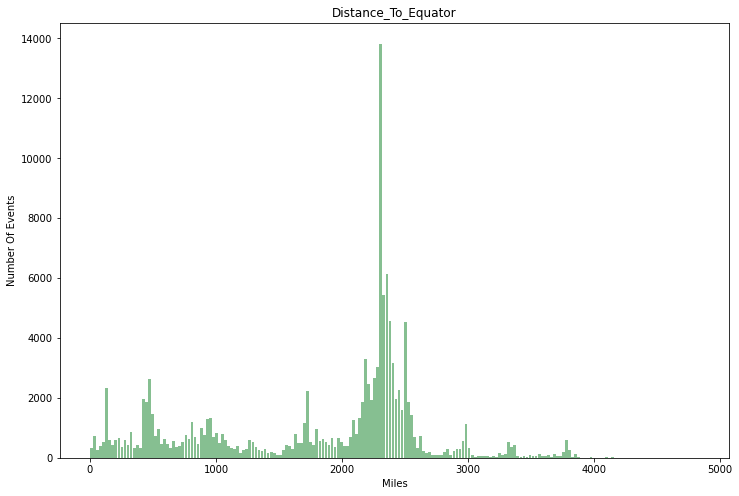

In [7]:

#Distance of Event From the Equator
EquatorDist = terrordata.hist(column='Distance_To_Equator',bins=200, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9, sharex=True, sharey=True)
for ax in EquatorDist.flatten():
    ax.set_xlabel("Miles")
    ax.set_ylabel("Number Of Events")
    

#1 #15 Percent of All Events Were At a Capital City
print(len(combined_data[combined_data['Capital_City_Event'] == True]) / len(terrordata))
#0.15212124929087256


Capital_City_Event = combined_data[combined_data['Capital_City_Event'] == True]
print(Capital_City_Event['Event_Distance'].mean())
# The average distance of events are within 5 miles of the center of the city.


Complete


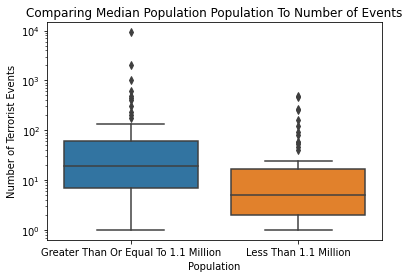

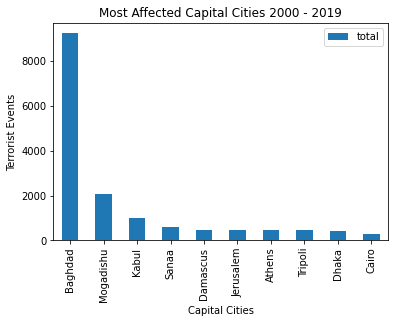

In [8]:




#Plot Showing that The Bigger The City The More Likely A Terrorist Event Can Happen. I divide up the Capital Cities To Greater Than Median And Less Than Median
grouped_City_Data = Capital_City_Event.groupby(['city', 'population']).size().reset_index(name='total')
grouped_City_Data['population_per_million'] = grouped_City_Data['population'] / 1000000
grouped_City_Data['Greater_Or_Equal_To_Median'] = np.where(grouped_City_Data['population_per_million'] >= grouped_City_Data['population_per_million'].median(), "Greater Than Or Equal To 1.1 Million", "Less Than 1.1 Million")
ax = sns.boxplot(x='Greater_Or_Equal_To_Median', y='total', data=grouped_City_Data)
ax.set_yscale("log")
ax.set(xlabel="Population", ylabel="Number of Terrorist Events", )
ax.set_title('Comparing Median Population Population To Number of Events')




Most_Affected_Capitals = grouped_City_Data[['city','total','population']].nlargest(10,'total')
#Most Effected Capital Cities
Capt_Cities = Most_Affected_Capitals.plot.bar(x="city", y="total")
plt.title('Most Affected Capital Cities 2000 - 2019')
plt.ylabel('Terrorist Events')
plt.xlabel('Capital Cities')

print("Complete")